In [8]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from glob import glob
import math

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px

import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import os # used for navigating to image path
import imageio # used for writing images

import datetime

from PIL import Image
from PIL import ImageFile

##not sure why I need this but I do
ImageFile.LOAD_TRUNCATED_IMAGES = True

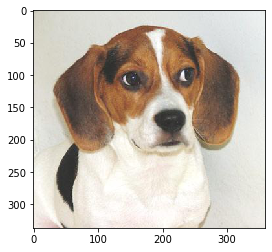

In [5]:
## Load the image
data = plt.imread('/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/n02088364-beagle/n02088364_4527.jpg')

# Display the image
plt.imshow(data)
plt.show()

In [7]:
file_paths = []
image_ids = []
breed_labels = []

directory_name = '/Users/ilya/Desktop/Computer-Science/U-Capstone/Images/'

for directory in os.listdir(directory_name):
    if directory != '.DS_Store':
        for file in os.listdir(directory_name+str(directory)):
            file_paths.append(directory_name
                              +str(directory)+'/'+str(file))
            breed_labels.append(str(directory).split('-')[1])
            image_ids.append(file)

df = pd.DataFrame()

df['file_path'] = file_paths
df['image_id'] = image_ids
df['breed_label'] = breed_labels

df

,file_path,image_id,breed_label
0,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_26.jpg,silky_terrier
1,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_4869.jpg,silky_terrier
2,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_595.jpg,silky_terrier
3,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_9222.jpg,silky_terrier
4,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_422.jpg,silky_terrier
...,...,...,...
20575,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_237.jpg,black
20576,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_222.jpg,black
20577,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_1021.jpg,black
20578,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02089078_183.jpg,black


In [9]:
#figuring out heights and widths of each image for better processing

list_of_heights = []
list_of_widths = []

for path in df['file_path']:
    image = load_img(path)
    np_array = img_to_array(image)
    list_of_heights.append(np_array.shape[0])
    list_of_widths.append(np_array.shape[1])

df.loc[:,('img_height')] = list_of_heights
df.loc[:,('img_width')] = list_of_widths

In [10]:
img_size = df[['img_height','img_width']]

img_size.describe()

,img_height,img_width
count,20580.000000,20580.000000
mean,385.861224,442.531876
std,124.863446,142.792308
min,100.000000,97.000000
25%,333.000000,361.000000
50%,375.000000,500.000000
75%,453.000000,500.000000
max,2562.000000,3264.000000


In [11]:
#binning a dataframe above by size for better visualization

img_size.loc[:,('img_height_bin')] = pd.cut(img_size['img_height'], list(range(0,4004, 100)))

img_size.loc[:,('img_width_bin')] = pd.cut(img_size['img_width'], list(range(0,4004, 100)))

img_size = img_size[img_size['img_height'] <= 2000]

img_size = img_size[img_size['img_width'] <= 2000]

heights = img_size.groupby('img_height_bin').count()[['img_height']].reset_index()
widths = img_size.groupby('img_width_bin').count()[['img_width']].reset_index()

heights.loc[:,('img_height_bin')] = heights['img_height_bin'].astype('str')
heigths2 = heights.rename(columns = {'img_height':'height_img_count'})

widths.loc[:,('img_width_bin')] = widths['img_width_bin'].astype('str')
widths2 = widths.rename(columns = {'img_width':'width_img_count'})

sizes_df = heigths2.merge(widths2, left_index = True, right_index = True).rename(columns = {'img_height_bin':'size'})\
           [['size','height_img_count','width_img_count']]

sizes_df.head(4)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,size,height_img_count,width_img_count
0,"(0, 100]",3,2
1,"(100, 200]",901,808
2,"(200, 300]",2233,1847
3,"(300, 400]",11395,4779


In [12]:
import plotly.graph_objects as go

sizes_mini_df = sizes_df.head(10)
sizes = sizes_df['size']

fig = go.Figure(data=[
    go.Bar(name='heights', x=sizes, y=sizes_mini_df['height_img_count']),
    go.Bar(name='widths', x=sizes, y=sizes_mini_df['width_img_count'])
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(height = 500, width = 1000)
fig.show()

In [13]:
#we count the number of dog images per breed discovering the fact the the dataset in slightly imbalanced

breed_count_df = df.groupby('breed_label').count().reset_index()\
                .rename(columns = {'file_path':'dog_count'})[['breed_label','dog_count']]\
                .sort_values(by = 'dog_count', ascending = False)

fig = px.bar(breed_count_df, x='breed_label', y='dog_count')

fig.update_layout(title_text = 'Image Count by Breed',
                  yaxis_title = 'Number of Images',
                  xaxis_title = 'Dog Breed')

fig.update_layout(height = 900, width = 1500)

fig.show()

In [14]:
df2 = df.merge(breed_count_df, left_on= 'breed_label', right_on = 'breed_label')
df3 = df2.sample(frac = 1)
df4 = df3[df3.dog_count > 160]
df5 = df4[['file_path','image_id','breed_label']]
df5

,file_path,image_id,breed_label
16316,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02088466_7004.jpg,bloodhound
8292,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02090721_2340.jpg,Irish_wolfhound
3370,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02110063_12294.jpg,malamute
14284,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02096294_6905.jpg,Australian_terrier
137,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02097658_8690.jpg,silky_terrier
...,...,...,...
4818,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02110185_13434.jpg,Siberian_husky
13476,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02099712_4133.jpg,Labrador_retriever
9149,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02091467_1330.jpg,Norwegian_elkhound
11878,/Users/ilya/Desktop/Computer-Science/U-Capston...,n02087394_2324.jpg,Rhodesian_ridgeback


In [16]:
train_df = df5.iloc[0:round(len(df5)*0.8)]
test_df = df5.iloc[round(len(df5)*0.8):]

In [18]:
test_df.to_csv('/Users/ilya/Desktop/Computer-Science/U-Capstone/raw_data/test_true_labels.npy')

In [19]:
def img_to_np_array(path):
    image = Image.open(path)
    image = image.resize((224,224))
    #image = image.convert('L')
    image = np.array(image)
    return image

In [25]:
train_data = []

for file_path, label in zip(train_df['file_path'], train_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    train_data.append([img_np_array, label])

train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data])

train_images = train_images.reshape(-1, 224, 224, 3)
train_labels = pd.get_dummies(train_labels).to_numpy()

In [23]:
test_data = []

for file_path, label in zip(test_df['file_path'], test_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    test_data.append([img_np_array, label])

test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

test_images = test_images.reshape(-1, 224, 224, 3)
test_labels = pd.get_dummies(test_labels).to_numpy()

In [24]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(2245, 224, 224, 3)
(2245, 59)


NameError: name 'test_images' is not defined

In [12]:
np.save('/Users/ilya/Desktop/U-Capstone/data/train_images3.npy', train_images)
print("Train images saved!")
np.save('/Users/ilya/Desktop/U-Capstone/data/train_labels3.npy', train_labels)
print("Train labels saved!")
train_labels_df.to_csv('/Users/ilya/Desktop/U-Capstone/data/train_label_names.csv')
print("Train label names saved!")

np.save('/Users/ilya/Desktop/U-Capstone/data/test_images3.npy', test_images)
print("Test images saved!")
np.save('/Users/ilya/Desktop/U-Capstone/data/test_labels3.npy', test_labels)
print("Test labels saved!")
test_labels_df.to_csv('/Users/ilya/Desktop/U-Capstone/data/test_label_names.csv')
print("Test label names saved!")

Train images saved!
Train labels saved!
Train label names saved!
Test images saved!
Test labels saved!
Test label names saved!


In [11]:
test_data = []

time1 = datetime.datetime.now()

for file_path, breed_label ina zip(test_df['file_path'], test_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    test_data.append([img_np_array, breed_label])

np.random.shuffle(test_data)    

test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

test_images = test_images.reshape(-1, 250, 250, 1)
test_labels = pd.get_dummies(test_labels).to_numpy()
    
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
run_time = elapsedTime.total_seconds()

print('Run time: {} seconds'.format(run_time))

Run time: 4.955958 seconds


In [42]:
print("Shape of train image dataset: {}".format(train_images.shape))
#print("Shape of test image dataset: {}".format(test_images.shape))
print("Shape of train label dataset: {}".format(train_labels.shape))
#print("Shape of test label dataset: {}".format(test_labels.shape))

Shape of train image dataset: (3254, 200, 200, 1)
Shape of train label dataset: (3254, 15)


In [45]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D

# Initialize the model object
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(filters = 16, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu',
                 input_shape=(200, 200, 1)))

model.add(MaxPooling2D(pool_size = 2))

# Add a convolutional layer
model.add(Conv2D(filters = 32, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu'))

model.add(MaxPooling2D(pool_size = 2))

# Add a convolutional layer
model.add(Conv2D(filters = 64, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu'))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(15, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 64)       

In [46]:
training = model.fit(train_images, train_labels, batch_size = 100, epochs = 8, validation_split=0.3)
training

Epoch 1/8
23/23 [==============================] - 77s 3s/step - loss: 14.6252 - accuracy: 0.0830 - val_loss: 3.2436 - val_accuracy: 0.0522
Epoch 2/8
23/23 [==============================] - 72s 3s/step - loss: 2.9715 - accuracy: 0.0686 - val_loss: 2.7776 - val_accuracy: 0.0686
Epoch 3/8
23/23 [==============================] - 70s 3s/step - loss: 2.7453 - accuracy: 0.0710 - val_loss: 2.6996 - val_accuracy: 0.0829
Epoch 4/8
23/23 [==============================] - 65s 3s/step - loss: 2.6878 - accuracy: 0.1007 - val_loss: 2.6609 - val_accuracy: 0.1105
Epoch 5/8
23/23 [==============================] - 66s 3s/step - loss: 2.6653 - accuracy: 0.1134 - val_loss: 2.6694 - val_accuracy: 0.0983
Epoch 6/8
23/23 [==============================] - 64s 3s/step - loss: 2.6361 - accuracy: 0.1244 - val_loss: 2.6200 - val_accuracy: 0.1116
Epoch 7/8
23/23 [==============================] - 63s 3s/step - loss: 2.6112 - accuracy: 0.1171 - val_loss: 2.6491 - val_accuracy: 0.1075
Epoch 8/8
23/23 [=========

In [47]:
training_history_df = pd.DataFrame(training.history)
training_history_df = training_history_df.reset_index().rename(columns = {'index':'epoch'})
training_history_df

,epoch,loss,accuracy,val_loss,val_accuracy
0,0,8.569758,0.082565,3.243588,0.052201
1,1,2.895125,0.068072,2.777595,0.068577
2,2,2.722302,0.075977,2.699605,0.082907
3,3,2.689802,0.101449,2.660909,0.110542
4,4,2.659118,0.117260,2.669404,0.098260
5,5,2.635571,0.119895,2.620005,0.111566
6,6,2.624727,0.117260,2.649070,0.107472
7,7,2.614452,0.131752,2.611243,0.158649


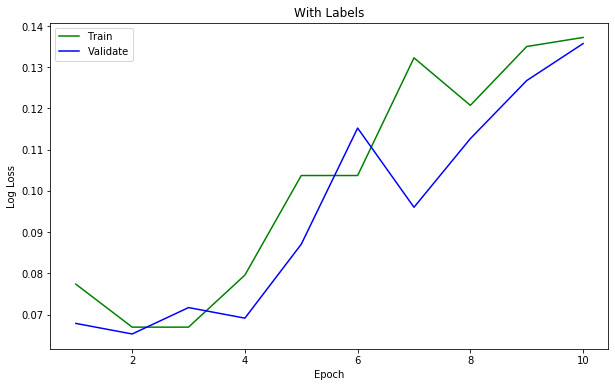

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.plot(list(range(1,11)), training.history['accuracy'], color='green', label="Train")
plt.plot(list(range(1,11)), training.history['val_accuracy'], color='blue', label="Validate")

plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("With Labels")

plt.legend(loc='best')
plt.show()

In [37]:
model.evaluate(test_images, test_labels)

21/21 [==============================] - 7s 305ms/step - loss: 2.6073 - accuracy: 0.1306


[2.607325792312622, 0.13056835532188416]

In [13]:
# Get predicted probabilities for test dataset
y_probs = model.predict(test_images)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis = 1)

y_preds

# Indices corresponding to test images which were mislabeled
#bad_test_idxs = np.where(y_preds != y_test)[0]

NameError: name 'model' is not defined

In [48]:
samoyed = img_to_np_array('/Users/ilya/Desktop/russian-bee.png').reshape(1,60,60,1)

ValueError: cannot reshape array of size 40000 into shape (1,60,60,1)

In [46]:
prediction = model.predict(samoyed)

In [57]:
%pprint

Pretty printing has been turned OFF


In [47]:
label_list = list(train_labels_df.columns)
label_list

['Afghan_hound',
 'Airedale',
 'Bernese_mountain_dog',
 'EntleBucher',
 'Great_Pyrenees',
 'Irish_wolfhound',
 'Leonberg',
 'Maltese_dog',
 'Pomeranian',
 'Samoyed',
 'Scottish_deerhound',
 'Sealyham_terrier',
 'Shih',
 'Tibetan_terrier',
 'basenji']

In [48]:
prediction_list = list(prediction[0])
prediction_list

[0.061776843,
 0.06985099,
 0.05059278,
 0.056825694,
 0.05707421,
 0.05678923,
 0.06951023,
 0.08338115,
 0.094307125,
 0.055790253,
 0.070337705,
 0.07566053,
 0.06818018,
 0.06824093,
 0.06168212]

In [49]:
predict_dict = {}

for a, b in zip(label_list, prediction_list):
    predict_dict[a] = b

In [50]:
predict_dict

{'Afghan_hound': 0.061776843,
 'Airedale': 0.06985099,
 'Bernese_mountain_dog': 0.05059278,
 'EntleBucher': 0.056825694,
 'Great_Pyrenees': 0.05707421,
 'Irish_wolfhound': 0.05678923,
 'Leonberg': 0.06951023,
 'Maltese_dog': 0.08338115,
 'Pomeranian': 0.094307125,
 'Samoyed': 0.055790253,
 'Scottish_deerhound': 0.070337705,
 'Sealyham_terrier': 0.07566053,
 'Shih': 0.06818018,
 'Tibetan_terrier': 0.06824093,
 'basenji': 0.06168212}